In [77]:
import pandas as pd
import seaborn as sns
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.experimental import enable_iterative_imputer  # noqa
from sklearn.impute import IterativeImputer
from sklearn.neighbors import NearestNeighbors
from scipy.stats import mode
from sklearn.base import BaseEstimator, TransformerMixin


In [78]:
from sklearn.metrics import nan_euclidean_distances
class KNNCategoricalImputer(BaseEstimator, TransformerMixin):
    """
    Impute missing values in a categorical column using k-nearest neighbors.
    
    For each row with a missing value in `target_col`, this transformer:
      - Uses only rows (from fit) that have complete predictor values.
      - Computes distances using only the available predictor values (ignoring missing ones)
        via nan_euclidean_distances.
      - Imputes the missing value using the mode of the target values among the k-nearest neighbors.
    """
    def __init__(self, target_col, predictors, n_neighbors=5):
        self.target_col = target_col
        self.predictors = predictors
        self.n_neighbors = n_neighbors

    def fit(self, X, y=None):
        # Use only rows where the target is present and all predictors are complete.
        self.complete_data_ = X[
            X[self.target_col].notnull() & X[self.predictors].notnull().all(axis=1)
        ].copy()
        # Fit NearestNeighbors on these complete rows (using predictors).
        # We won't use the NN model in transform because our row might have NaNs;
        # instead, we will use nan_euclidean_distances.
        return self

    def transform(self, X, y=None):
        X = X.copy()
        missing_mask = X[self.target_col].isnull()
        if missing_mask.sum() == 0:
            return X
        
        for idx in X[missing_mask].index:
            # Get the predictor row as a DataFrame (to preserve feature names)
            row = X.loc[[idx], self.predictors]
            # Compute distances between the row and complete data using nan_euclidean_distances.
            # This function will compute the Euclidean distance on only those features that are non-missing.
            dists = nan_euclidean_distances(row, self.complete_data_[self.predictors])
            # Get indices of the n_neighbors smallest distances.
            sorted_indices = np.argsort(dists[0])
            # If fewer than n_neighbors are available, use all of them.
            n_use = min(self.n_neighbors, len(sorted_indices))
            selected_indices = sorted_indices[:n_use]
            neighbor_values = self.complete_data_.iloc[selected_indices][self.target_col]
            # Use mode (most frequent value) among neighbors for imputation.
            m = mode(neighbor_values)
            imputed_value = m.mode[0] if isinstance(m.mode, np.ndarray) else m.mode
            X.at[idx, self.target_col] = imputed_value
        return X


In [79]:
class SeparateImputer(BaseEstimator, TransformerMixin):
    """
    Impute missing values using different strategies:
      - For categorical columns (e.g., beds, size): use KNNCategoricalImputer (only complete predictor rows are used).
      - For numerical columns (e.g., maint, D_mkt): use IterativeImputer (MICE).
    """
    def __init__(self, cat_cols, num_cols, n_neighbors=5, random_state=0, max_iter=10):
        self.cat_cols = cat_cols
        self.num_cols = num_cols
        self.n_neighbors = n_neighbors
        self.random_state = random_state
        self.max_iter = max_iter
        self.num_imputer = IterativeImputer(random_state=self.random_state, max_iter=self.max_iter)
        self.cat_imputers = {}  # a dict to hold a KNNCategoricalImputer for each categorical column

    def fit(self, X, y=None):
        # Fit numerical imputer on the specified numerical columns.
        if self.num_cols:
            self.num_imputer.fit(X[self.num_cols])
        # For each categorical column, create and fit a KNNCategoricalImputer.
        # For predictors, we use all columns except 'price' and the target categorical column.
        for col in self.cat_cols:
            predictors = [c for c in X.columns if c not in ['price', col]]
            imputer = KNNCategoricalImputer(target_col=col, predictors=predictors, n_neighbors=self.n_neighbors)
            imputer.fit(X)
            self.cat_imputers[col] = imputer
        return self

    def transform(self, X, y=None):
        X = X.copy()
        # Impute categorical columns using our custom KNN imputer.
        for col, imputer in self.cat_imputers.items():
            X = imputer.transform(X)
        # Impute numerical columns using MICE.
        if self.num_cols:
            X[self.num_cols] = self.num_imputer.transform(X[self.num_cols])
        return X

In [80]:
class RealEstateDataCleaner(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.size_mapping = {
            '0-499 sqft': 0,
            '500-999 sqft': 1,
            '1000-1499 sqft': 2,
            '1500-1999 sqft': 3,
            '2000-2499 sqft': 4,
            '2500-2999 sqft': 5,
            '3000-3499 sqft': 6,
            '5500-3999 sqft': 7,
            '4000+ sqft': 8
        }
        self.exposure_mapping = {
            'S': 0,
            'No': 1,
            'We': 2,
            'E': 3
        }
        self.den_mapping = {
            'No': 0,
            'YES': 1
        }
        self.parking_mapping = {
            'N': 0,
            'Yes': 1
        }
        self.ward_mapping = {
            'W10': 10,
            'W11': 11,
            'W13': 13
        }

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        X = X.copy()
        if 'id_' in X.columns:
            X.drop('id_', axis=1, inplace=True)
        X = X[X['price'].notna()]
        if X['size'].dtype == object:
            X['size'] = X['size'].map(self.size_mapping)
        if X['exposure'].dtype == object:
            X['exposure'] = X['exposure'].map(self.exposure_mapping)
        if X['DEN'].dtype == object:
            X['DEN'] = X['DEN'].map(self.den_mapping)
        if X['parking'].dtype == object:
            X['parking'] = X['parking'].map(self.parking_mapping)
        if X['ward'].dtype == object:
            X['ward'] = X['ward'].map(self.ward_mapping)
        return X

# Build the complete pipeline.
data_pipeline = Pipeline([
    ('cleaner', RealEstateDataCleaner()),
    ('imputer', SeparateImputer(
        cat_cols=['beds', 'size'],      # Categorical columns imputed using our KNN-based method.
        num_cols=['maint', 'D_mkt'],      # Numerical columns imputed using MICE.
        n_neighbors=5,
        random_state=0,
        max_iter=10))
])

In [81]:

df = pd.read_csv("SDSS Datathon Cases/Real Estate/real-estate-data.csv")
df

,id_,ward,beds,baths,DEN,size,parking,exposure,D_mkt,building_age,maint,price,lt,lg
0,219129,W13,3.0,3,No,1500-1999 sqft,N,No,16.0,9,1087.0,1821000.0,43.617997,-79.392383
1,757581,W13,1.0,1,YES,500-999 sqft,Yes,We,23.0,3,469.0,613000.0,43.648968,-79.390031
2,404196,W13,2.0,2,YES,500-999 sqft,Yes,We,12.0,1,767.0,838000.0,43.641045,-79.375436
3,821441,W13,2.0,2,No,500-999 sqft,Yes,S,10.0,25,827.0,935000.0,43.642122,-79.370250
4,612090,W10,2.0,1,No,NaN,N,S,5.0,1,NaN,1328000.0,43.692210,-79.365015
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3037,715398,W13,2.0,2,No,1500-1999 sqft,N,S,1.0,1,1183.0,1657000.0,43.648766,-79.418944
3038,104338,W10,1.0,1,YES,0-499 sqft,N,E,2.0,11,649.0,589000.0,43.672338,-79.377044
3039,476334,W13,2.0,2,YES,1500-1999 sqft,Yes,No,0.0,17,1023.0,1386000.0,43.636830,-79.412187
3040,413482,W10,1.0,1,YES,500-999 sqft,N,No,7.0,25,659.0,774000.0,43.669317,-79.408047


In [82]:
cleaned_df = data_pipeline.fit_transform(df)
cleaned_df

,ward,beds,baths,DEN,size,parking,exposure,D_mkt,building_age,maint,price,lt,lg
0,13,3.0,3,0,3.0,0,1,16.0,9,1087.000000,1821000.0,43.617997,-79.392383
1,13,1.0,1,1,1.0,1,2,23.0,3,469.000000,613000.0,43.648968,-79.390031
2,13,2.0,2,1,1.0,1,2,12.0,1,767.000000,838000.0,43.641045,-79.375436
3,13,2.0,2,0,1.0,1,0,10.0,25,827.000000,935000.0,43.642122,-79.370250
4,10,2.0,1,0,1.0,0,0,5.0,1,753.390062,1328000.0,43.692210,-79.365015
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3037,13,2.0,2,0,3.0,0,0,1.0,1,1183.000000,1657000.0,43.648766,-79.418944
3038,10,1.0,1,1,0.0,0,3,2.0,11,649.000000,589000.0,43.672338,-79.377044
3039,13,2.0,2,1,3.0,1,1,0.0,17,1023.000000,1386000.0,43.636830,-79.412187
3040,10,1.0,1,1,1.0,0,1,7.0,25,659.000000,774000.0,43.669317,-79.408047


In [83]:
cleaned_df.to_csv('cleaned_data.csv')

<Axes: xlabel='price', ylabel='Count'>

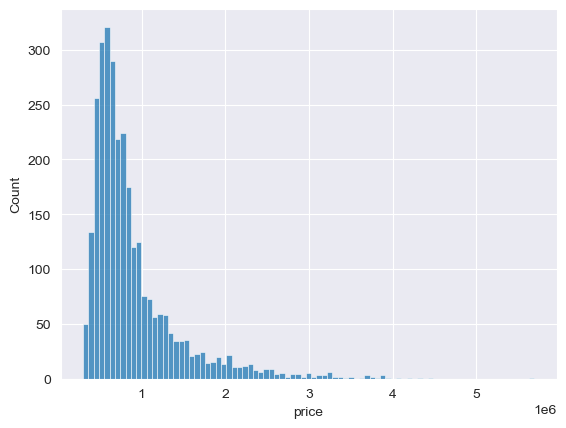

In [7]:
sns.histplot(data=df['price'])

In [10]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

# Suppose your dataframe is called df and you have features x1, x2, ...
model = smf.glm(
    formula='price ~ ward + beds + baths + DEN + size + parking + exposure + D_mkt + building_age + maint + lt + lg',
    data=df,
    family=sm.families.Gamma(link=sm.families.links.log())
).fit()
print(model.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  price   No. Observations:                 2749
Model:                            GLM   Df Residuals:                     2726
Model Family:                   Gamma   Df Model:                           22
Link Function:                    log   Scale:                        0.026470
Method:                          IRLS   Log-Likelihood:                -36209.
Date:                Sat, 01 Mar 2025   Deviance:                       72.342
Time:                        13:35:22   Pearson chi2:                     72.2
No. Iterations:                    14   Pseudo R-squ. (CS):             0.9999
Covariance Type:            nonrobust                                         
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                 66

/Users/meersisodia/anaconda3/lib/python3.10/site-packages/statsmodels/genmod/families/links.py:13: FutureWarning: The log link alias is deprecated. Use Log instead. The log link alias will be removed after the 0.15.0 release.
  warnings.warn(


In [12]:
coeff_table = pd.DataFrame({
    'Coefficient': model.params,
    'Std Error': model.bse,
    't-value': model.tvalues,
    'p-value': model.pvalues
})
coeff_table.index.name = 'Variable'


coeff_table

,Coefficient,Std Error,t-value,p-value
Variable,,,,
Intercept,66.313857,31.190031,2.126123,3.349298e-02
ward[T.W11],-0.007181,0.012289,-0.584371,5.589707e-01
ward[T.W13],-0.067746,0.013396,-5.057146,4.255767e-07
DEN[T.YES],0.047936,0.006682,7.173589,7.305655e-13
size[T.1000-1499 sqft],0.487513,0.013243,36.812252,1.175705e-296
size[T.1500-1999 sqft],0.644112,0.018924,34.036100,6.517421e-254
size[T.2000-2499 sqft],0.681178,0.026370,25.831086,3.969529e-147
size[T.2500-2999 sqft],0.610086,0.041509,14.697544,6.684006e-49
size[T.3000-3499 sqft],0.661722,0.049634,13.332018,1.507645e-40
